# Active-learning tutorial: Preparing and evaluating committee MACE models for protonated water clusters

In this tutorial, we will be preparing and working a **committee of MACE models** to describe two different **protonated water clusters** in the gas phase 
and illustrate the important aspects of committee-based active learning using **query by committee (QbC)**.

In the first part, we will leverage the accessible uncertainty measure to screen a wide pool of candidate geometries originating from a DFT simulation of the **Zundel cation** (H$_5$O$_2^+$) to **create a robust and concise training data set**.

In the second part, we will use the obtained model to perform an **exploratory simulation** of the related **Eigen cation** (H$_9$O$_3^+$) and, once again, rely on active learning to select the most relevant training structures
in order for the model to gain accuracy on a new, unexplored part of the configuration space.

## First step: import necessary modules

This is all the modules and functions that we will need to run this tutorial.
Apart from standard Python libraties, we built our own simple QbC functionality for this purpose which can be found (with additional helper tools) in `myfunctions.py`.

Having a developer-level understanding of these tools is not critical for completing the tutorial in any way,
but please do have a look if you are curious.

In [1]:
import os, logging, multiprocessing
from tqdm.notebook import tqdm
from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.visualize import view
from ase.io import read, write # read and write structures
from ase.calculators.calculator import Calculator, all_changes, all_properties

# import functions to run this tutorial
from myfunctions import train_mace                # train MACE model
from myfunctions import eval_mace                 # evaluate MACE model
from myfunctions import extxyz2energy             # extract energy from extxyz file
from myfunctions import extxyz2array              # extract forces from extxyz file
from myfunctions import run_qbc                   # run Query by Committee
from myfunctions import run_single_aims_structure # call FHI-aims

/Users/krystofbrezina/Software/miniconda3/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


In [2]:
plt.style.use('notebook.mplstyle')

# Part I: Generating a training set for the Zundel cation from active learning

In the first part, we will tackle the Zundel cation (shown below) using a committee of MACE models.
To actively select structures for the training set, we need to perform QbC on a provided candidate set.

In [19]:
# TODO: make a dedicated single-frame xyz file for this purpose
view(read('./init-train/structures/test.extxyz', index=0), viewer='x3d')

In the cell below we will select some hyperparameters of the employed MACE models and the QbC process.

## TODO

Let the students fill some of these?

In [4]:
# MACE committee
n_init_train = 20
n_test = 50  
n_committee = 4
parallel = False

# QbC
n_iter_qbc = 10
n_add_iter = 10    

# random number set up - is it necessary to have this expliticly here?
np.random.seed(0) 
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

In [5]:
# folders for tidy work
md_folder = "md"
init_train_folder = "init-train"
qbc_folder = "qbc-work" # if you modify this, add the new folder to .gitignore
Eigen_qbc_folder = "eigen-qbc-work"

os.makedirs(f'{init_train_folder}', exist_ok=True)
os.makedirs(f'{init_train_folder}/config', exist_ok=True)
os.makedirs(f'{init_train_folder}/models', exist_ok=True)
os.makedirs(f'{init_train_folder}/eval', exist_ok=True)
os.makedirs(f'{init_train_folder}/structures', exist_ok=True)
os.makedirs(f'{md_folder}', exist_ok=True)

## Select initial training structures

The first step in QbC is to select a small number of random structures (here `n_init_train`) to train a very preliminary committee that can, however, already provide a measure of uncertainty.

We start by selecting these initial structures and, at the same time, separating out a small portion of our data points for testing purposes.

In [13]:
# Read the all the structures from file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')

Total number of structures: 1000


In [17]:
# visualize structures
# TODO: can we make a trajectory visualization with x3d?
view(structures[0], viewer='x3d')

In [5]:
# Create the initial training and test sets
selected_indices = np.random.choice(len(structures), size=(n_init_train + n_test), replace=False)
remaining_candidate_idcs = np.delete(np.arange(len(structures)), selected_indices)

indices_train = selected_indices[:n_init_train]
indices_test = selected_indices[n_init_train:]
assert len(indices_train) == n_init_train
assert len(indices_test) == n_test

print(f'\nSelected indices for training:\n\t{indices_train}')
print(f'\nSelected indices for test:\n\t{indices_test}')

initial_training_set = [structures[i] for i in indices_train]
test_set = [structures[i] for i in indices_test]
remaining_structures = [structures[i] for i in remaining_candidate_idcs]

print(f"\nSaving the initial training set to '{init_train_folder}structures/init.train.extxyz'")
write(f'{init_train_folder}/structures/init.train.extxyz', initial_training_set, format='extxyz')

print(f"\nSaving the test set to '{init_train_folder}/structures/test.extxyz'")
write(f'{init_train_folder}/structures/test.extxyz', test_set, format='extxyz')

print(f"\nSaving the remaining structures to '{init_train_folder}/structures/remaining.extxyz'")
write(f'{init_train_folder}/structures/remaining.extxyz', remaining_structures, format='extxyz')


Selected indices for training:
	[895 605 298 356 571 834  27 231 306 708 522 891 988 239 863  55 635 175
  14  77]

Selected indices for test:
	[ 31 483 310 311 931 790  45 103 729   1 772 712 758 451 457 738 799 367
 922 267 230 192 530 700 251 689 821 141 316 482 331 295 262 434 864 372
 272 270 503 319 557 986 142 202 796 196 264 533 252 578]

Saving the initial training set to 'init-trainstructures/init.train.extxyz'

Saving the test set to 'init-train/structures/test.extxyz'

Saving the remaining structures to 'init-train/structures/remaining.extxyz'


## Initial Training

Now we get to the initial training of the committee.
In essence, you can understand this as the entry step of QbC being done separately with the aim to really illustrate what is going in.

Notice that we provide `structures/init.train.set.extxyz` as the training data set.

## TODO:
Explain this well and let the students fill some obvious/educative of the MACE input

In [6]:
# Define different values for each config
for i in range(n_committee):
    filename = f"{init_train_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# num_radial_basis: 5
# num_cutoff_basis: 3

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
# valid_batch_size: 4
# valid_fraction: 0.2
max_num_epochs: 10000 # this is basically early stopping
patience: 20

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{init_train_folder}/models"
log_dir        : "{init_train_folder}/log"
checkpoints_dir: "{init_train_folder}/checkpoints"
results_dir    : "{init_train_folder}/results"
train_file     : "{init_train_folder}/structures/init.train.extxyz"

# why this does not work?
# test_file      : "{init_train_folder}/structures/test.extxyz"

energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 10
E0s: 
  1: -13.7487804074635
  8: -2045.41865185226
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: False
"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote init-train/config/config.0.yml
Wrote init-train/config/config.1.yml
Wrote init-train/config/config.2.yml
Wrote init-train/config/config.3.yml


In [20]:
# train a committee of MACE models
def train_single_model(n):
    train_mace(f"{init_train_folder}/config/config.{n}.yml")
    
if parallel: # parallel version: it should take around 25s 
    print(f"Training {n_committee} models in parallel")
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))
        
else: # serial version: it should take around 1m
    print(f"Training {n_committee} models in serial\n")
    for n in range(n_committee):
        print(f"Training model {n}")
        train_single_model(n)
        
for n in range(n_committee):
    os.remove(f"{init_train_folder}/models/mace.com={n}.model")
        
# clean_output(init_train_folder,n_committee)

Training 4 models in serial

Training model 0
Training model 1
Training model 2
Training model 3


## Evaluation of the committee disagreement 

Now that we have our preliminary model, we will ask it to predict the energies on all remaining structures in the candidate pool that have not been selected into the training set yet.

That will be accomplished with the function `eval_mace()` and will allow us to evaluate several very important quantities.

The first is the **average committee energy prediction** 

$$
\overline{E}(\mathbf{q}_i) 
= \frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} E_n(\mathbf{q}_i),
$$

which is an important quantity in committee based models because it is typically a more accurate prediction and represents the potential energy surface on which MD is performed.

To that end, we also have the **average committee force prediction** on the $\alpha$-th atom

$$
\overline{\mathbf{F}}_{\alpha}(\mathbf{q}_i) 
= \frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} \mathbf{F}_{\alpha, n}(\mathbf{q}_i).
$$

The second one is the **committee disagreement on energy** which we define as the standard deviation of the energy predicitons

$$
\sigma_E(\mathbf{q}_i)
= \sqrt{\frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} \left[ E_n(\mathbf{q}_i) - \overline{E}(\mathbf{q}_i) \right]^2}.
$$

Consistently, we have a **committee disagreement on per-atom forces**

$$
\sigma_{F_\alpha}(\mathbf{q}_i)
= \sqrt{\frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} \left[ \mathbf{F}_{\alpha, n}(\mathbf{q}_i) - \overline{\mathbf{F}}_\alpha(\mathbf{q}_i) \right]^2}.
$$

and an averaged **committee disagreement on forces**

$$
\sigma_F(\mathbf{q}_i)
= \frac{1}{N_\mathrm{atoms}} \sum_{n}^{N_\mathrm{atoms}} \sigma_{F_\alpha}(\mathbf{q}_i).
$$

This quantity is the centerpiece of QbC and is preferred over $\sigma_E$ for several practical reasons.

It serves as an uncertainty measure: the more the committee members disagree, the less sure they are about what the correct output should actually be.

As such, the committee disagreement *correlates* with the actual error of prediction (*i.e.*, the generalization error) but it is important to remember that they are not the same quantity! We will come back to this shortly.

In [21]:
# Predict with all MACE committee members
for n in tqdm(range(n_committee)):
    eval_mace(f'{init_train_folder}/models/mace.com={n:d}_compiled.model',
              'init-train/structures/remaining.extxyz',
              f'{init_train_folder}/eval/train_{n:02d}.extxyz')   

  0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
# read in predicted energies, evaluate average energies and disagreements
forces         = np.array([extxyz2array(f'{init_train_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_forces') 
                           for n in tqdm(range(n_committee))])
avg_forces     = forces.mean(axis=0)   # (1000, 7, 3)

disagreement_f = forces.std(axis=0)    # (1000, 7, 3)
tot_dis_f      = np.mean(np.linalg.norm(disagreement_f,axis=2),axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

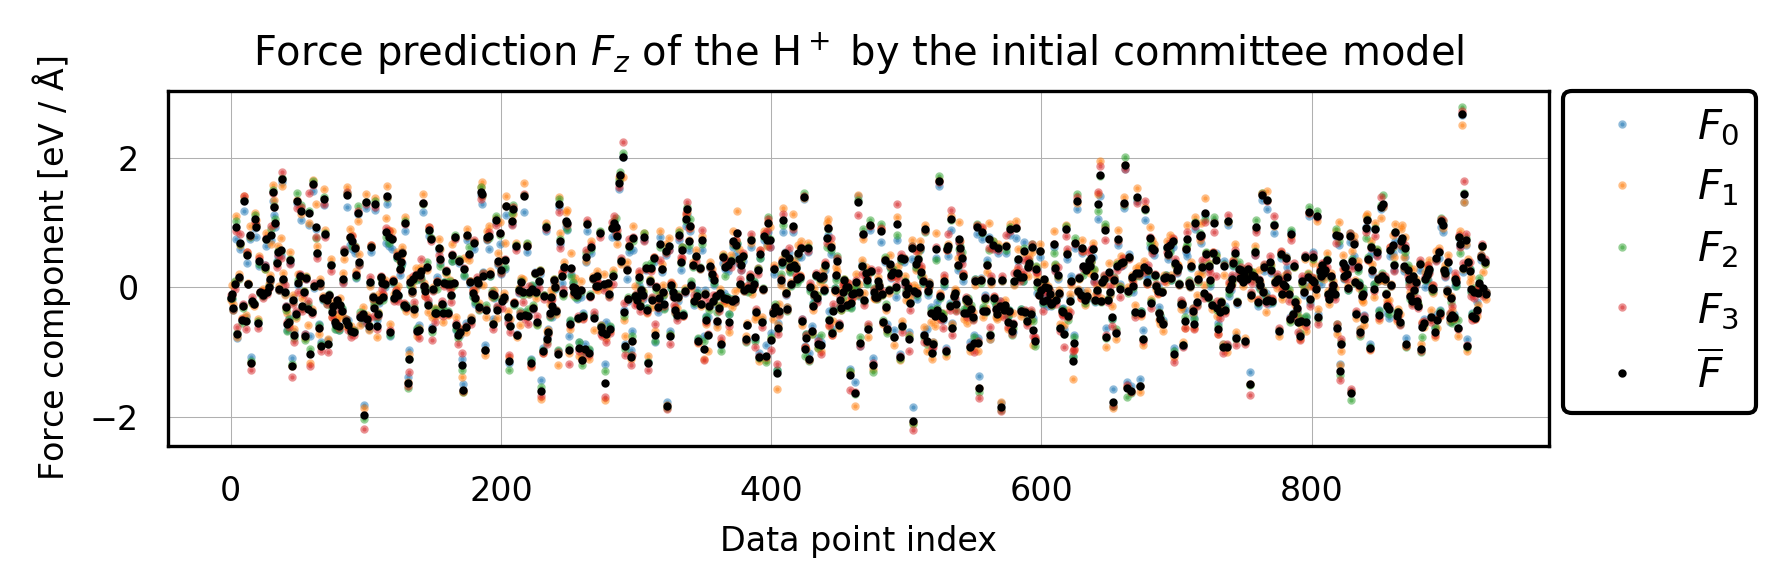

In [57]:
for n, f in enumerate(forces):
    plt.plot(f[:, -1, -1], 'o', markersize=1, label=rf'$F_{n:d}$', alpha=0.5, linewidth=0.5)
plt.plot(avg_forces[:, -1, -1], 'o', markersize=1, label=r'$\overline{F}$', color='k',linewidth=0.5)
plt.legend(loc="upper right",bbox_to_anchor=(1.15, 1), borderaxespad=0.)
plt.xlabel('Data point index')
plt.ylabel(r'Force component [eV / $\mathrm{\AA}$]')
plt.title('Force prediction $F_z$ of the H$^+$ by the initial committee model')
plt.tight_layout();

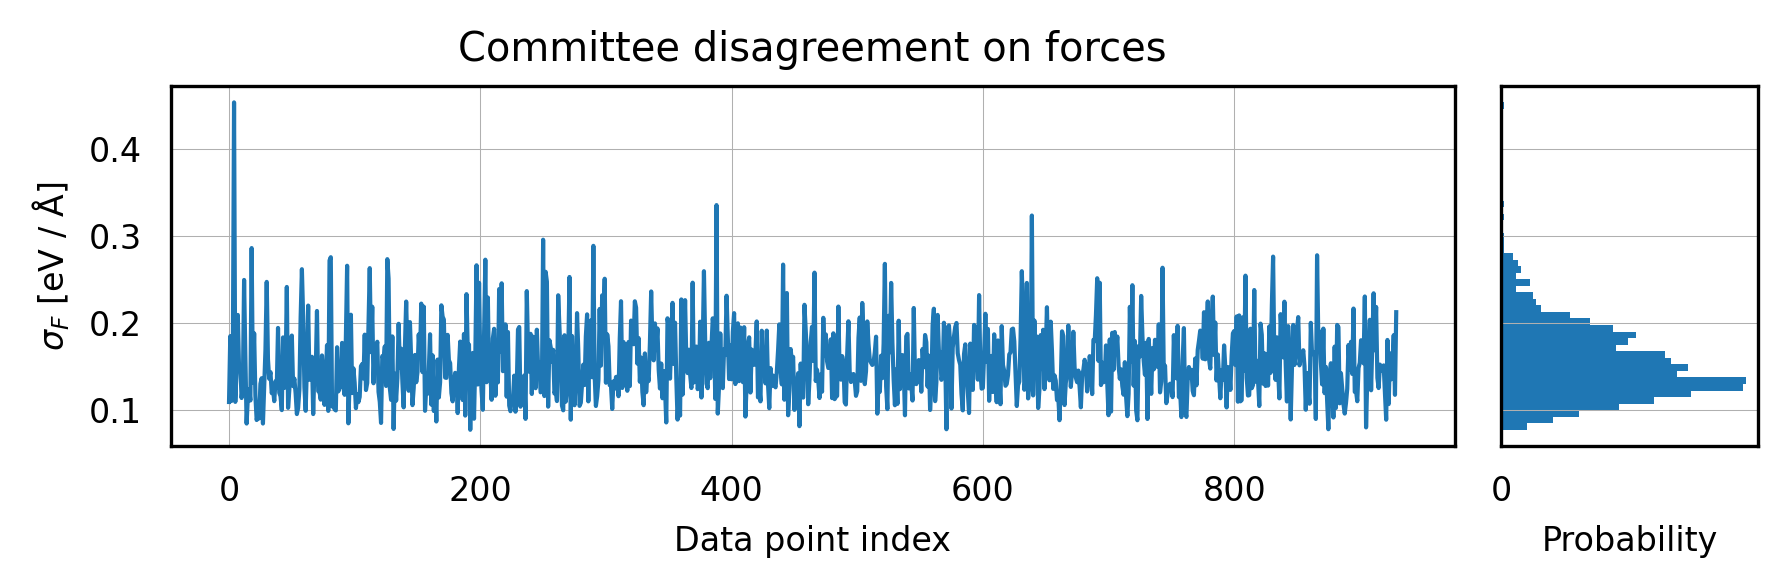

In [54]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))
ax[0].plot(tot_dis_f)
ax[0].set_ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
ax[0].set_xlabel('Data point index')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')

ax[1].hist(tot_dis_f, bins=50, orientation='horizontal', density=True)
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])

plt.tight_layout();

# Select relevant training data via query by committee

At this point, we have an initial committee model that can predict $\sigma_F$ for arbitrary data points from the remaining candidate pool.

With this ability in our hands, we can now proceed to the actual execution of the QbC procedure.

There one iteratively predicts $\sigma_F$ over the remaining candidate pool, selects a fixed number of candidate geometries that feature the **highest** $\sigma_F$ and adds them to the training set and retrains the committee.

If you are curious about a detailed insight, have a look at the function `run_qbc()` contained in the `myfunctions.py` file. 

## TODO
Think about how we want to spend the 10 minutes while the QbCs are running.

In [55]:
# Run QbC
os.makedirs(qbc_folder, exist_ok=True)
os.makedirs(f'{qbc_folder}/config', exist_ok=True)
# seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"{qbc_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 10000 # this is basically early stopping
patience: 10       # we are a bit in a rush

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{qbc_folder}/models"
log_dir        : "{qbc_folder}/log"
checkpoints_dir: "{qbc_folder}/checkpoints"
results_dir    : "{qbc_folder}/results"

train_file: "{qbc_folder}/train-iter.extxyz"
# test_file : "{init_train_folder}/structures/test.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 100



E0s: 
  1: -13.7487804074635
  8: -2045.41865185226
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: True
distributed: False

"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote qbc-work/config/config.0.yml
Wrote qbc-work/config/config.1.yml
Wrote qbc-work/config/config.2.yml
Wrote qbc-work/config/config.3.yml


In [56]:
# Attention: this function will not restart from a previously stopped run
run_qbc(
    init_train_folder=init_train_folder,
    init_train_file=f"{init_train_folder}/structures/init.train.extxyz", # initial training dataset
    fn_candidates=f'{init_train_folder}/structures/remaining.extxyz',    # candidate structures
    test_dataset=f'{init_train_folder}/structures/test.extxyz',          # test set
    n_iter=n_iter_qbc,                                                   # number of QbC iterations
    config=f'{qbc_folder}/config',                                       # folder with config files
    ofolder=qbc_folder,                                                  # folder to save the QBC results
    n_add_iter=n_add_iter,                                               # number of structures to add in each iteration
    recalculate_selected=False,                                          # whether to recalculate the selected structures with DFT (part 2)
    parallel=parallel
);
# it should take 9m

Starting QbC.
Number of models: 4
Number of iterations: 10
Number of new candidates at each iteration: 10
Candidates file: init-train/structures/remaining.extxyz
Test file: init-train/structures/test.extxyz

	--------------------------------------------------------------------
	Start of QbC iteration 1/10

	Started at: 2025-06-06 12:40:00
	Predicting committee disagreement across the candidate pool.
	Picking 10 new highest-disagreement data points.
	Retraining committee.
	training duration:   13.49 seconds

	Results:
	               Disagreement (pool): 0.081840 eV
	           Disagreement (selected): 0.162360 eV
	                New training set size: 30
	               New candidate set size: 920
	Ended at:   2025-06-06 12:40:23
	Duration:   22.54 seconds

	--------------------------------------------------------------------
	Start of QbC iteration 2/10

	Started at: 2025-06-06 12:40:23
	Predicting committee disagreement across the candidate pool.
	Picking 10 new highest-disagreement

### Monitoring QbC convergence

How does one know when the QbC cycle has converged? Simply setting a threshold value for $\sigma_F$ is not the best idea since one does not *a priori* know what it should be.

A better way to look at it is to consider the QbC converged once all the *unlearned* information has been extracted from the candidate set and nothing new remains for the committee to learn.

To visualize this, we can plot the evolution of $\sigma_F$ for each new added batch of structures and see how that comes closer to the value of $\sigma_F$ averaged over the candidate pool.

In practice, one will be always selecting from the high-end tail of the disagreement distribution of the candidates, so one stops the QbC once those curves reach a plateau.

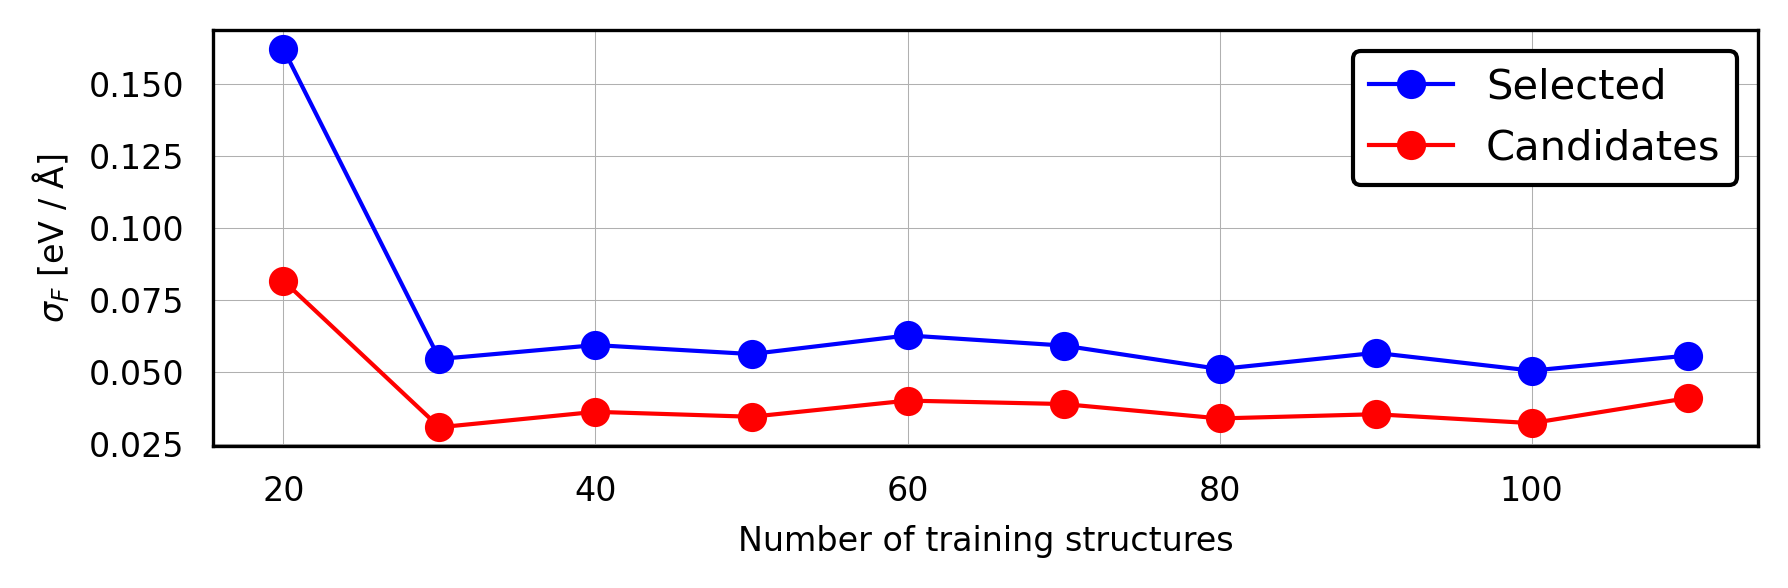

In [95]:
n_training_structures = np.arange(n_init_train, (n_iter_qbc * n_add_iter) + n_init_train, n_add_iter)
sigma = np.loadtxt('qbc-work/disagreement.txt').T

plt.plot(n_training_structures, sigma[0], '-o', label='Selected', color="blue")
plt.plot(n_training_structures, sigma[1], '-o', label='Candidates', color="red")
plt.legend()
plt.xlabel('Number of training structures')
plt.ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
plt.tight_layout();

## Relation between $\sigma_F$ and the generalization error

Here, we will demonstrate that $\sigma_F$ is a *measure* of uncertainty, but is not equivalent to the **generalization error**, *i.e.*, the actual error of the model in prediction performed on previously unseen data.

In order to do this, we do an identical exercise as before: we let the committee predict on the remaining candidate structures, which will give us the predicted forces from which we derive the disagreement $\sigma_F$.

Then, since the initial candidate set is labeled, we take the **reference forces** and calculate the generalization as the RMSE
$$
\text{RMSE}_F =
\sqrt{\frac{1}{N} \sum_{\alpha=1}^{N} \left( \mathbf{F}_\alpha - \mathbf{F}_\alpha^\text{ref} \right)^2}
$$

and simply correlate the two quantities.

In [64]:
# Predict with all MACE committee members
for n in tqdm(range(n_committee)):
    eval_mace(f'{qbc_folder}/models/mace.com={n:d}_compiled.model',
              'init-train/structures/remaining.extxyz',
              f'{qbc_folder}/eval/train_{n:02d}.extxyz')  

  0%|          | 0/4 [00:00<?, ?it/s]

In [65]:
forces = np.array([extxyz2array(f'{qbc_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_forces') 
                           for n in tqdm(range(n_committee))])
avg_forces = forces.mean(axis=0)   # (1000, 7, 3)
disagreement_f = forces.std(axis=0)    # (1000, 7, 3)
tot_dis_f = np.mean(np.linalg.norm(disagreement_f, axis=2), axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [70]:
ref_forces = np.array(extxyz2array('init-train/structures/remaining.extxyz', keyword='REF_forces'))
rmse = np.sqrt(((avg_forces - ref_forces)**2).mean(axis=(1, 2)))

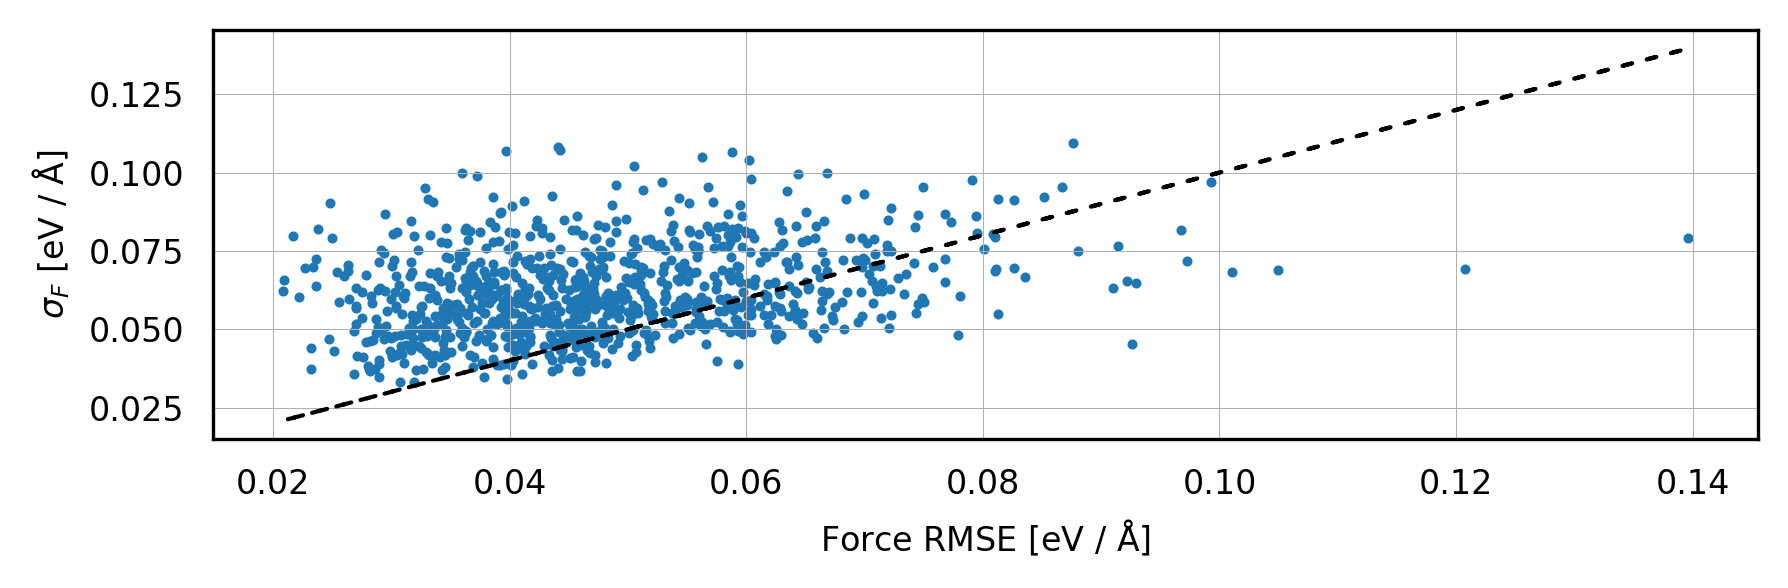

In [85]:
plt.plot(rmse, rmse, color='k', dashes=(2, 4), dash_capstyle='round')
plt.scatter(rmse, tot_dis_f, s=2)
plt.xlabel(r'Force RMSE [eV / $\mathrm{\AA}$]')
plt.ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
plt.tight_layout();

A correlation is clear. This makes sense, since the two quantities are related by their physical meaning, but they are nowhere near identical. However...

## TODO

At this point, Shubham could briefly tell the students how you can rescale the forces to correct this correlation, make $\sigma$ actually represent the generalization error and propagate that error to various interesting quantities.

## Test dataset

Elia: please check that whatever I'm doing is correct, I rewrote your code for forces, but I'm not 100% sure.

After showing the corrected plot below, please report the total error of the obtained model over this test set and make a well visible print out of these - these numbers are something that any MLP person can relate to easily.

In [92]:
forces = None
all_forces = None
for i_iter in range(n_iter_qbc):
    predictions = [None] * n_committee
    for n_model in range(n_committee):
        file = f"{qbc_folder}/eval/test.model={n_model}.iter={i_iter}.extxyz"
        structures = read(file, index=":")
        if forces is None:
            forces = np.zeros((len(structures), n_committee, 7, 3))
            all_forces = np.zeros((n_iter_qbc, len(structures), n_committee, 7, 3))
        forces[:, n_model] = [atoms.arrays["MACE_forces"] for atoms in structures]
    all_forces[i_iter, ...] = forces
np.save(f"{qbc_folder}/test-energy.npy", all_forces)

In [101]:
disagreement = np.std(all_forces, axis=(2, 3, 4))
disagreement_mean = np.mean(disagreement, axis=1)

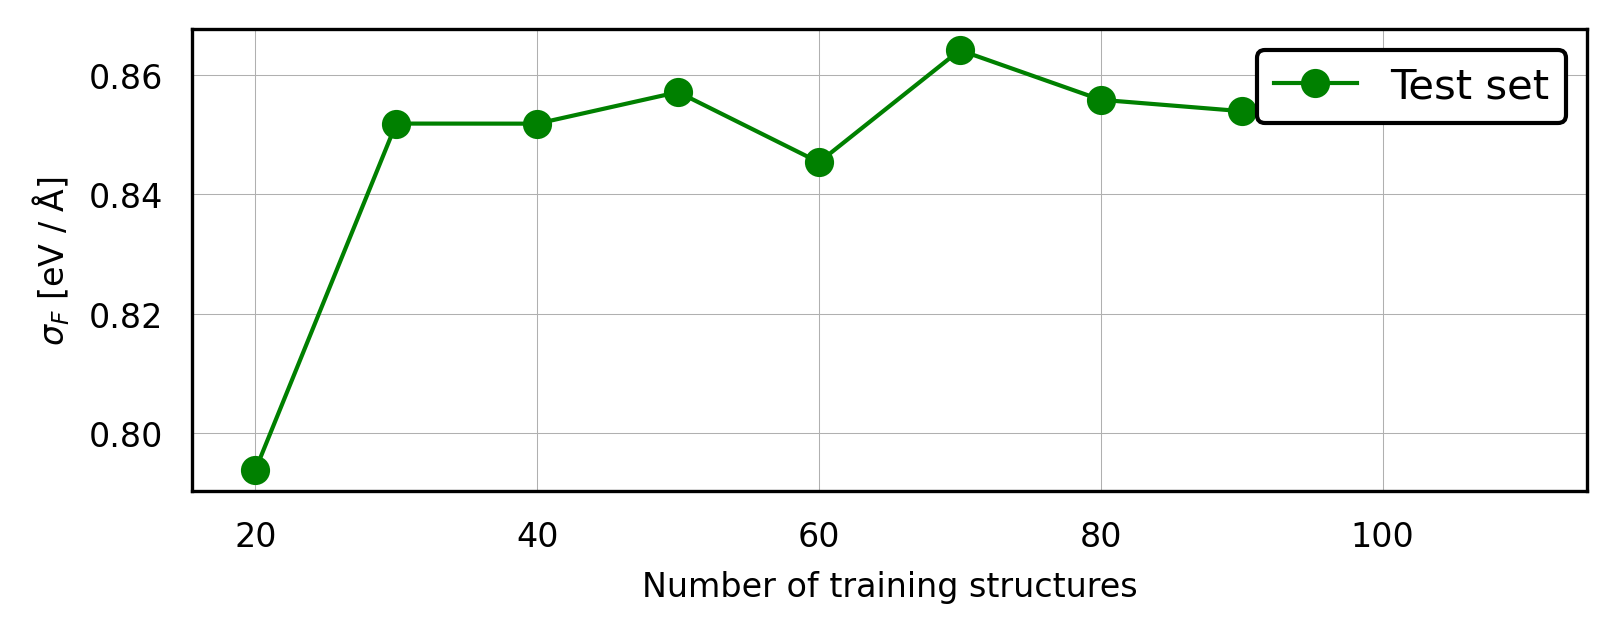

In [105]:
n_training_structures = np.arange(n_init_train, (n_iter_qbc * n_add_iter) + n_init_train, n_add_iter)
plt.plot(n_training_structures, disagreement_mean, "-o", label="Test set", color="green")
plt.legend()
plt.xlabel('Number of training structures')
plt.ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
plt.show()

## Part II

## Part III

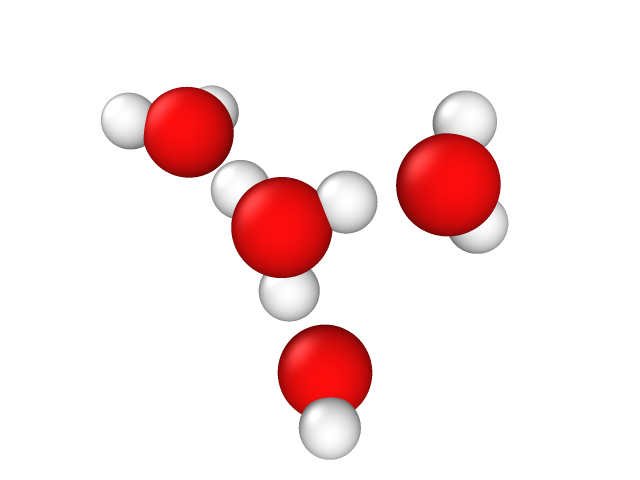

In [17]:
display(Image(filename='../initial-datasets/eigen/eigen.png'))

In [18]:
# Run Q
os.makedirs(Eigen_qbc_folder, exist_ok=True)
os.makedirs(f'{Eigen_qbc_folder}/config', exist_ok=True)
# seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"{Eigen_qbc_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 10000 # this is basically early stopping
patience: 10       # we are a bit in a rush

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{Eigen_qbc_folder}/models"
log_dir        : "{Eigen_qbc_folder}/log"
checkpoints_dir: "{Eigen_qbc_folder}/checkpoints"
results_dir    : "{Eigen_qbc_folder}/results"

train_file: "{Eigen_qbc_folder}/train-iter.extxyz"
# test_file : "{init_train_folder}/structures/test.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 100



E0s: 
  1: -13.7487804074635
  8: -2045.41865185226
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: True
distributed: False

"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote eigen-qbc-work/config/config.0.yml
Wrote eigen-qbc-work/config/config.1.yml
Wrote eigen-qbc-work/config/config.2.yml
Wrote eigen-qbc-work/config/config.3.yml


In [19]:
_shared_logger = None  # Global singleton

def get_shared_logger(log_path='fhi_aims_calculator.log'):
    global _shared_logger
    if _shared_logger is None:
        logger = logging.getLogger("FHIaimsLogger")
        logger.setLevel(logging.INFO)
        logger.propagate = False  # Avoid duplicate output if root logger is also configured

        # Create handler only once
        handler = logging.FileHandler(log_path, mode='a')
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)

        _shared_logger = logger
    return _shared_logger
    
class FHIaimsCalculator(Calculator):
    implemented_properties = ['energy', 'free_energy', 'forces', 'stress']

    # Shared logger
    logger = get_shared_logger()

    def __init__(self, aims_command, control_file, directory='.', output_path="aims.out", **kwargs):
        super().__init__(**kwargs)
        self.aims_command = aims_command
        self.control_file = control_file
        self.directory = directory
        self.output_path = output_path

    def calculate(self, atoms: Atoms = None, properties=all_properties, system_changes=all_changes):
        super().calculate(atoms, properties, system_changes)
        os.makedirs(self.directory, exist_ok=True)

        # Paths
        geom_path = os.path.join(self.directory, 'geometry.in')
        control_path = os.path.join(self.directory, 'control.in')
        output_path = os.path.join(self.directory, self.output_path)

        # RUN = False
        # if os.path.exists(output_path):
        #     try:
        #         output_atoms = read(output_path, format="aims-output")
        #         if not np.allclose(output_atoms.get_positions(), atoms.get_positions()) \
        #                 or not np.allclose(output_atoms.get_cell().T, atoms.get_cell().T):
        #             RUN = True
        #     except Exception as e:
        #         # self.logger.warning(f"Failed to read {output_path}: {e}")
        #         RUN = True
        # else:
        #     RUN = True

        # if RUN:
        cmd = f"{self.aims_command} > {self.output_path} 2>/dev/null"
        self.logger.info(f"Running AIMS command: {cmd}")
        run_single_aims_structure(atoms, self.directory, cmd, self.control_file)

        # After run: check output
        if not os.path.exists(output_path) or os.path.getsize(output_path) == 0:
            self.logger.error(f"AIMS output not found or empty in {output_path}")
            raise RuntimeError(f"AIMS calculation failed in '{self.directory}'")

        try:
            output_atoms = read(output_path, format="aims-output")
        except Exception as e:
            self.logger.error(f"Failed to read AIMS output in {output_path}: {e}")
            raise RuntimeError(f"Failed to parse AIMS output: {e}")


        try:
            output_atoms = read(output_path, format="aims-output")
        except Exception as e:
            self.logger.error(f"Failed to parse output at {output_path}: {e}")
            raise e

        self.results = {
            "energy": output_atoms.get_potential_energy(),
            "free_energy": output_atoms.get_potential_energy(),
            "forces": output_atoms.get_forces(),
            "stress": np.zeros(6)
        }
        self.logger.info(f"Calculation completed in '{self.directory}'")


# FHI-aims executable
aims_path = "/Users/krystofbrezina/build/FHIaims/build/aims.250507.scalapack.mpi.x"
assert os.path.exists(aims_path), "executable not found"

# ase.Calculator factory
def calculator_factory(n:int,filepath:str):
    os.makedirs('eigen-qbc-work',exist_ok=True)
    os.makedirs('eigen-qbc-work/aims',exist_ok=True)
    directory = f'eigen-qbc-work/aims/run-{n}'
    os.makedirs(directory,exist_ok=True)
    calculator = FHIaimsCalculator(aims_command=f"mpirun -n 4 {aims_path}",
                               control_file="../aims/control.in",
                               directory=directory,
                               output_path="aims.out")
    return calculator

# # usage example
# atoms = read("../initial-datasets/eigen/eigen.xyz") # read the structure
# calculator = calculator_factory(0,None)             # create the calculator
# atoms.calc = calculator                             # assign the calculator
# atoms.get_potential_energy() # trigger              # call the calculator

In [22]:
# Attention: this function will not restart from a previously stopped run
run_qbc(
    init_train_folder="qbc-work/",
    init_train_file="qbc-work/structures/train-iter.n=9.extxyz",   # initial training dataset
    fn_candidates=f'../checkpoints/eigen-inference/train.extxyz',  # candidate structures
    test_dataset=None,                                             # test set
    n_iter=2,                                                      # number of QbC iterations
    config='eigen-qbc-work/config',                                # folder with config files
    ofolder='eigen-qbc-work',                                      # folder to save the QBC results
    n_add_iter=5,                                                  # number of structures to add in each iteration
    recalculate_selected=True,                                     # whether to recalculate the selected structures with DFT (part 2)
    calculator_factory=calculator_factory,
    parallel=False
);

Starting QbC.
Number of models: 4
Number of iterations: 2
Number of new candidates at each iteration: 5
Candidates file: ../checkpoints/eigen-inference/train.extxyz
Test file: None

	--------------------------------------------------------------------
	Start of QbC iteration 1/2

	Started at: 2025-06-05 13:23:04
	Predicting committee disagreement across the candidate pool.
	Picking 5 new highest-disagreement data points.
	Recalculating ab initio energies and forces for new data points.
	Ab initio calculations:   5/  5
	Time spent in ab initio calculations:   213.39 seconds
	Retraining committee.
	training duration:   55.84 seconds

	Results:
	               Disagreement (pool): 0.213481 eV
	           Disagreement (selected): 0.343763 eV
	                New training set size: 125
	               New candidate set size: 295
	Ended at:   2025-06-05 13:27:38
	Duration:   274.17 seconds

	--------------------------------------------------------------------
	Start of QbC iteration 2/2

	St